In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# 1. Load data

In [2]:
url = 'https://www.dropbox.com/s/06dpd184dig2jcp/0_all_deval_prices.csv?dl=1'
df = pd.read_csv(url)
df.head()

,Year,Low,Medium,High,Car,Year_made
0,2011,12700,18600,20200,Volkswagen Tiguan,2011
1,2012,17900,19900,21400,Volkswagen Tiguan,2011
2,2013,10000,13300,16300,Volkswagen Tiguan,2011
3,2014,10000,12400,15500,Volkswagen Tiguan,2011
4,2015,10300,13200,15900,Volkswagen Tiguan,2011


In [3]:
# reduce memory usage if available
def reduce_mem_usage(df, verbose=True):
    """
    Change pandas dtypes to reduce memory usage
    Input:
        df, pandas DataFrame
        verbose, bool, if True print message
    Output:
        pandas DataFrame
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        # reduced memory usage in percent
        diff_pst = 100 * (start_mem - end_mem) / start_mem
        msg = f'Mem. usage decreased to {end_mem:5.2f} Mb ({diff_pst:.1f}% reduction)'
        print(msg)
    return df

# reduce memory usage
df = reduce_mem_usage(df)

Mem. usage decreased to  0.39 Mb (16.7% reduction)


In [4]:
# add new features

# create new columns with car's model and manufaturer's names
df['Manufacturer'] = df.Car.apply(lambda x: x.split()[0])
df['Model'] = df.Car.apply(lambda x: " ".join(x.split()[1:]))
# calculate number of years since car was manufactured
df['Years_old'] = df['Year'] - df['Year_made']
# calculate percentage change per each price segment
for col_name in ['Low', 'Medium', 'High']:
    # calcualte percentage price changes
    df[f'PCT_change_{col_name}'] = (df[col_name] / df[col_name].shift(1) - 1) * 100
    
# price change for cars sold during same year as it was manucatured should be equal to zero
df.loc[df.Years_old==0, [f'PCT_change_{col_name}' for col_name in ['Low', 'Medium', 'High']]] = 0
df.head()

,Year,Low,Medium,High,Car,Year_made,Manufacturer,Model,Years_old,PCT_change_Low,PCT_change_Medium,PCT_change_High
0,2011,12700,18600,20200,Volkswagen Tiguan,2011,Volkswagen,Tiguan,0,0.000000,0.000000,0.000000
1,2012,17900,19900,21400,Volkswagen Tiguan,2011,Volkswagen,Tiguan,1,40.944882,6.989247,5.940594
2,2013,10000,13300,16300,Volkswagen Tiguan,2011,Volkswagen,Tiguan,2,-44.134078,-33.165829,-23.831776
3,2014,10000,12400,15500,Volkswagen Tiguan,2011,Volkswagen,Tiguan,3,0.000000,-6.766917,-4.907975
4,2015,10300,13200,15900,Volkswagen Tiguan,2011,Volkswagen,Tiguan,4,3.000000,6.451613,2.580645


# 2. Exploratory Data Analysis

Data contains outliers. Example below shows `Seat Ateca` average price changes from autoplius.
![Outliers](https://www.dropbox.com/s/jvr04uxmwtr54ui/Seat_Ateca~2017.png?raw=1 "seat_example")

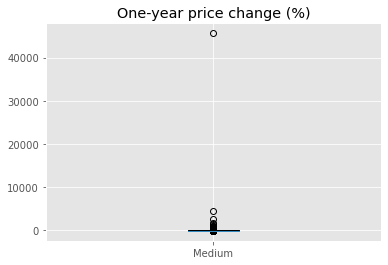

In [5]:
# example of outliers
fig, ax = plt.subplots()
ax.set_title('One-year price change (%)')
ax.boxplot(df.PCT_change_Medium);
ax.set_xticklabels(['Medium']);
# outliers make it imposible to view devaluation ranges

In [6]:
# use 5-95 percent range to filter out outliers for each price segment

# create new DataFrame without price change outliers 
# exclude sales with 0 year old cars
df_no = df.loc[df.Years_old != 0].copy()
# substitute outlier values with numpy NANs
for col_name in ['Low', 'Medium', 'High']:
    cond = df[f'PCT_change_{col_name}'] < df[f'PCT_change_{col_name}'].quantile(0.05)
    df_no.loc[cond, f'PCT_change_{col_name}'] = np.nan
    cond = df[f'PCT_change_{col_name}'] >  df[f'PCT_change_{col_name}'].quantile(0.95)
    df_no.loc[cond, f'PCT_change_{col_name}'] = np.nan
    
df_no.head()

,Year,Low,Medium,High,Car,Year_made,Manufacturer,Model,Years_old,PCT_change_Low,PCT_change_Medium,PCT_change_High
1,2012,17900,19900,21400,Volkswagen Tiguan,2011,Volkswagen,Tiguan,1,NaN,6.989247,5.940594
2,2013,10000,13300,16300,Volkswagen Tiguan,2011,Volkswagen,Tiguan,2,NaN,NaN,-23.831776
3,2014,10000,12400,15500,Volkswagen Tiguan,2011,Volkswagen,Tiguan,3,0.000000,-6.766917,-4.907975
4,2015,10300,13200,15900,Volkswagen Tiguan,2011,Volkswagen,Tiguan,4,3.000000,6.451613,2.580645
5,2016,9300,12100,14900,Volkswagen Tiguan,2011,Volkswagen,Tiguan,5,-9.708738,-8.333333,-6.289308


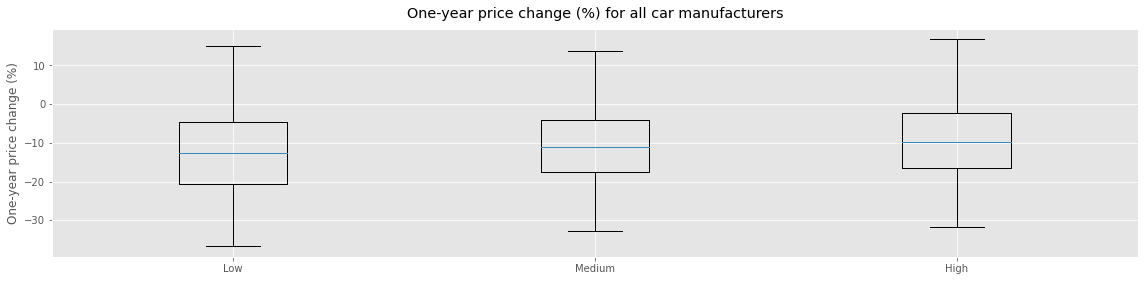

In [7]:
# plot results
fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title('One-year price change (%) for all car manufacturers', y=1.02)
# get data for boxplot (exclude NAN values)
boxplot_data = [df_no.PCT_change_Low.dropna(), df_no.PCT_change_Medium.dropna(), df_no.PCT_change_High.dropna()]
ax.boxplot(boxplot_data)
# rename x-axis
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylabel('One-year price change (%)')
plt.tight_layout()    

After removing outliers we can observed some prelimenary results:

* median price for more expensive models have lower changes (one would expect that more expensive car devaluates less),
* 75% of all price changes are <0% (majority of cars should cost less after one year). 

## 2.1 Yearly devaluation trends

Choose top 9 most popular (i.e. largest ammount of car models and information on yearly price changes)car manufacturers on autoplius.

In [8]:
# get top N manufacturers with largest ammount of data
N = 9
top_manu = df_no.groupby('Manufacturer')['PCT_change_Low'].count().sort_values().tail(N)
top_manu

Manufacturer
Volvo            297
Ford             301
Opel             308
Nissan           318
Audi             465
Toyota           582
Mercedes-Benz    608
Volkswagen       670
BMW              829
Name: PCT_change_Low, dtype: int64

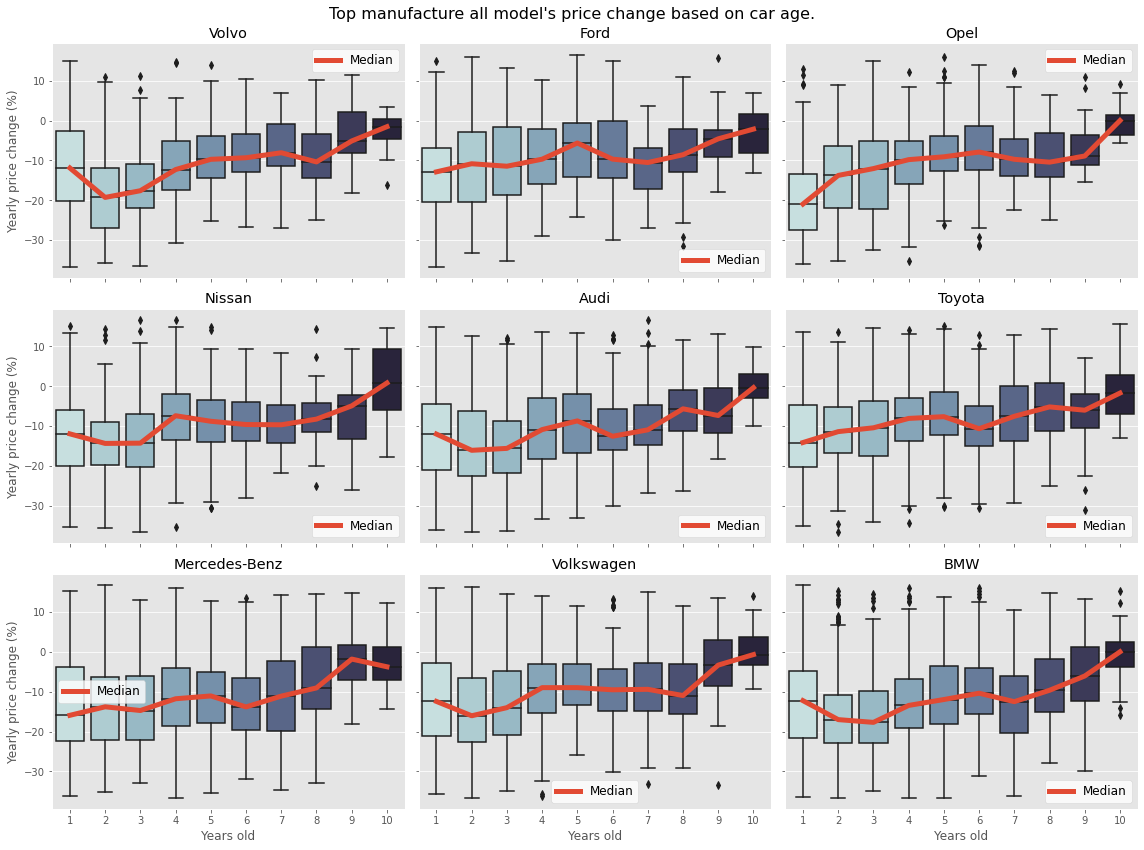

In [9]:
# plot results
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
axes = axes.flatten()

# add title to figure
fig.suptitle("Top manufacture all model's price change based on car age.", fontsize=16)

# iterate over top 6 car manufacturers 
for i, car_manu in enumerate(top_manu.index):
    # temporary DataFrame for plotting
    df_plot = df_no.loc[df_no.Manufacturer == car_manu]
    # reshape DataFrame for plotting
    df_plot = df_plot.iloc[:, [8, 9, 10, 11]].melt(id_vars='Years_old', var_name='Range', value_name='PCT_change')
    # box-plot plot
    sns.boxplot(x="Years_old", y="PCT_change", data=df_plot, ax=axes[i], palette='ch:start=.2,rot=-.3')    
    # add title
    axes[i].set_title(car_manu)
    # calculate median price change
    _median = df_plot.groupby('Years_old')['PCT_change'].median()
    axes[i].plot(_median.index-1, _median, linewidth=5, zorder=5, label='Median')
    # add legend with white background
    legend = axes[i].legend(frameon = 1, fontsize=12)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    
for ax in axes:
    ax.set(xlabel='Years old', ylabel='Yearly price change (%)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes:
    ax.label_outer()
    
plt.tight_layout()

# 3. Data modeling

## 3.1 Price devaluation estimation using linear models

1. get median price devalution for all models,
2. get median price devaluation for specific car manufacturer,
3. get median price devaluation for specific car model.

In [10]:
# transform data for calculateting medians
df_all = df.iloc[:, [0, 4, 5, 6, 7, 8, 9, 10, 11]].melt(id_vars=['Year', 'Car', 'Year_made', 'Manufacturer',
                                                                 'Model', 'Years_old'],
                                                        var_name='Range', value_name='PCT_change')
# rename values in Range column
df_all.Range = df_all.Range.replace({'PCT_change_Low': 'Low',
                                     'PCT_change_Medium': 'Medium',
                                     'PCT_change_High': 'High'})

# exclude cars sold same year as it was manufactured
df_all = df_all.loc[df_all.Years_old != 0].reset_index(drop=True)
df_all.head()

,Year,Car,Year_made,Manufacturer,Model,Years_old,Range,PCT_change
0,2012,Volkswagen Tiguan,2011,Volkswagen,Tiguan,1,Low,40.944882
1,2013,Volkswagen Tiguan,2011,Volkswagen,Tiguan,2,Low,-44.134078
2,2014,Volkswagen Tiguan,2011,Volkswagen,Tiguan,3,Low,0.000000
3,2015,Volkswagen Tiguan,2011,Volkswagen,Tiguan,4,Low,3.000000
4,2016,Volkswagen Tiguan,2011,Volkswagen,Tiguan,5,Low,-9.708738


In [11]:
# 1. get all prices changes for all car models
model_1 = df_all.groupby('Years_old')['PCT_change'].median()

# 2. get median price devaluation for specific car manufacturer
model_2 = df_all.loc[df_all.Manufacturer == 'Hyundai'].groupby('Years_old')['PCT_change'].median()

# 3. get median price devaluation for specific car model.
c_1 = df_all.Model == 'i30'
c_2 = df_all.Manufacturer == 'Hyundai'
model_3 = df_all.loc[c_1 & c_2].groupby('Years_old')['PCT_change'].median()

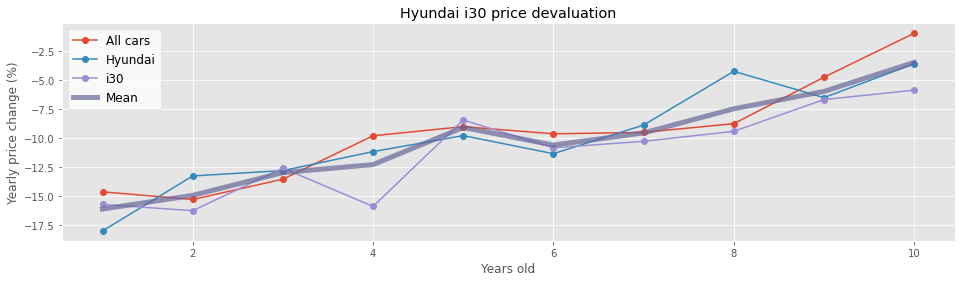

In [12]:
# visualize data
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.plot(model_1.index, model_1, 'o-', label='All cars')
ax.plot(model_2.index, model_2, 'o-', label='Hyundai')
ax.plot(model_3.index, model_3, 'o-', label='i30')

# calculate mean change
_mean = pd.DataFrame([model_1, model_2, model_3]).T.mean(axis=1)
ax.plot(_mean.index, _mean, '#666699', label='Mean', linewidth=5, alpha=0.7)

# add title
ax.set_title('Hyundai i30 price devaluation')

# set labels
ax.set(xlabel='Years old', ylabel='Yearly price change (%)')

# add legend with white background
legend = ax.legend(frameon = 1, fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('w')

In [13]:
def estimate_linear(car_manufacturer, car_model, year_made, price_brought, years_to_keep):
    """
    Function estimates car price after X number of years.
    Input:
        car_manufacturer,
        car_model,
        year_made,
        price_brought,
        years_to_keep
    """
    # 1. get all prices changes for all car models
    model_1 = df_all.groupby('Years_old')['PCT_change'].median()
    # 2. get median price devaluation for specific car manufacturer
    model_2 = df_all.loc[df_all.Manufacturer == car_manufacturer].groupby('Years_old')['PCT_change'].median()
    # 3. get median price devaluation for specific car model.
    c_1 = df_all.Model == car_model
    c_2 = df_all.Manufacturer == car_manufacturer
    model_3 = df_all.loc[c_1 & c_2].groupby('Years_old')['PCT_change'].median()
    # calculate mean change
    _mean = pd.DataFrame([model_1, model_2, model_3]).T.mean(axis=1)
    
    # how old was the car then it was brought
    start_year = 2021 - year_made
    
    # devaluate price
    for d in _mean.loc[start_year:start_year+years_to_keep]:
        price_brought *= (100+d)/100
    
    return int(price_brought)
    
# new price after 3 years  
estimate_linear('Hyundai', 'i30', 2015, 10000, 3)

7029

In [14]:
# new price after 3 years  
estimate_linear('Volkswagen', 'Golf', 2015, 10000, 3)

7093